# This notebook is for data cleaning and Exploratory Data Analysis, which will be used for user persona analysis

* Starbucks dataset: https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data
* `profile.csv` - dimensional data about each person, including their age, salary, and gender. There is one unique customer for each record
* `portfolio.csv` - information about the promotional offers that are possible to receive, and basic information about each one including the promotional type, duration of the promotion, reward, and how the promotion was distributed to customers
* `transcript.csv` - records show the different steps of promotional offers that a customer received. The different values of receiving a promotion are receiving, viewing, and completing. You also see the different transactions that a person made in the time since he became a customer. With all records, you see the day that they interacted with Starbucks and the amount that it is worth

## Settings

In [74]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import altair as alt

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

## Reading and exploring available data

### Profile data

In [3]:
df_p = pd.read_csv("./data/starbucks/profile.csv")

In [4]:
df_p.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,"112,000.00"
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,"100,000.00"
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Let us drop a redundant column

In [5]:
df_p.drop(columns='Unnamed: 0', inplace=True)

In [6]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
df_p.duplicated().sum()

0

In [8]:
df_p.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are some null values in the `gender` and `income` columns

In [9]:
df_p['id'].nunique()

17000

17,000 unique users in the dataset

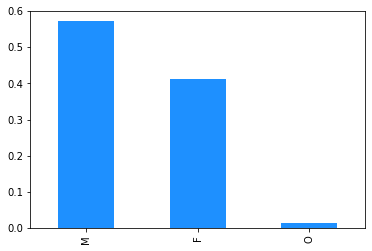

In [10]:
df_p['gender'].value_counts(normalize=True).plot.bar(color='dodgerblue');

In [11]:
df_p['gender'].value_counts(normalize=True)

M   0.57
F   0.41
O   0.01
Name: gender, dtype: float64

The majority of records belongs to Male users (57%)

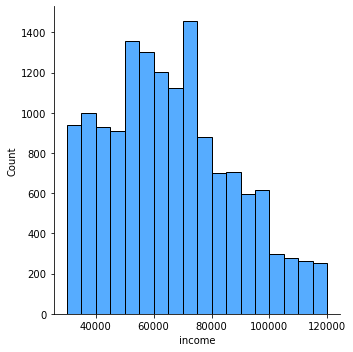

In [12]:
sns.displot(df_p, x="income", color='dodgerblue', binwidth=5000);

In [13]:
df_p['income'].describe()

count    14,825.00
mean     65,404.99
std      21,598.30
min      30,000.00
25%      49,000.00
50%      64,000.00
75%      80,000.00
max     120,000.00
Name: income, dtype: float64

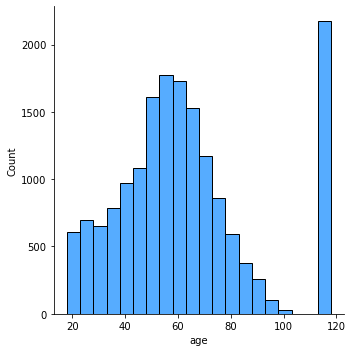

In [14]:
sns.displot(df_p, x="age", color='dodgerblue', binwidth=5);

There are some outliers in the `age` column

In [15]:
df_p['age'].describe(percentiles=[0.8, 0.9, 0.95, 0.98, 0.99])

count   17,000.00
mean        62.53
std         26.74
min         18.00
50%         58.00
80%         78.00
90%        118.00
95%        118.00
98%        118.00
99%        118.00
max        118.00
Name: age, dtype: float64

In [16]:
df_p[(df_p['age'] > 80) & (df_p['age'] <= 100)]

,gender,age,id,became_member_on,income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,"89,000.00"
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,"87,000.00"
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,"98,000.00"
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,"46,000.00"
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,"65,000.00"
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,"59,000.00"
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,"96,000.00"
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,"68,000.00"
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,"93,000.00"


In [17]:
df_p[df_p['age'] > 100]

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,NaN,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,NaN,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,NaN,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,NaN,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [18]:
df_p[df_p['age'] > 100]['income'].isnull().sum()

2175

In [19]:
df_p[df_p['age'] > 100]['gender'].isnull().sum()

2175

It seems that there are 2,175 users who didn't provide gender and income information. Also, these users identified themselves as over 100 y.o., which looks suspicious.

In [20]:
print (df_p.dtypes)

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object


`became_member_on` column has int data type

***How are we going to clean up the data?***

1. Deal with age over 100 y.o.
2. Deal with null values in `income` and `gender` columns
3. Change data type from int to datetime for `became_member_on` column

***What kind of new features we can create?***

1. `days_being_member` column can be created using `became_member_on` column
2. Change values for `gender`column. 
Instead of using F, M and O values, we can use numbers 1 - F, 2 - M, O - 3.

### Portfolio data

In [21]:
df_port = pd.read_csv("./data/starbucks/portfolio.csv")

In [22]:
df_port

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
# Drop redundant column
df_port.drop(columns=['Unnamed: 0'], inplace=True)

In [24]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [25]:
df_port['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [26]:
# Rename columns
df_port.columns = ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'offer_id']

### Transcript data

In [27]:
df_t = pd.read_csv("./data/starbucks/transcript.csv")

In [28]:
df_t.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [29]:
# Drop redundant column
df_t.drop(columns=['Unnamed: 0'], inplace=True)

In [30]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [31]:
df_t['person'].nunique()

17000

17,000 unique users as in the Profile data

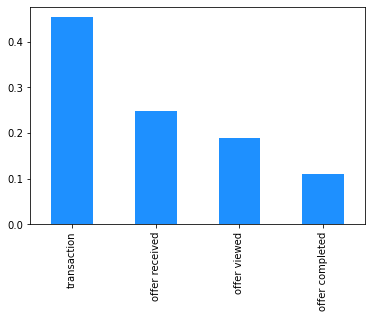

In [32]:
df_t['event'].value_counts(normalize=True).plot.bar(color='dodgerblue');

Let's check transactions only

In [33]:
df_t[df_t['event'] == 'transaction']['value'].unique().tolist()

["{'amount': 0.8300000000000001}",
 "{'amount': 34.56}",
 "{'amount': 13.23}",
 "{'amount': 19.51}",
 "{'amount': 18.97}",
 "{'amount': 33.9}",
 "{'amount': 0.22}",
 "{'amount': 18.59}",
 "{'amount': 18.01}",
 "{'amount': 19.11}",
 "{'amount': 36.19}",
 "{'amount': 6.46}",
 "{'amount': 5.02}",
 "{'amount': 28.39}",
 "{'amount': 28.08}",
 "{'amount': 0.75}",
 "{'amount': 1.02}",
 "{'amount': 13.57}",
 "{'amount': 10.22}",
 "{'amount': 31.42}",
 "{'amount': 27.89}",
 "{'amount': 4.2}",
 "{'amount': 13.05}",
 "{'amount': 1.16}",
 "{'amount': 38.38}",
 "{'amount': 4.08}",
 "{'amount': 5.78}",
 "{'amount': 14.27}",
 "{'amount': 11.52}",
 "{'amount': 13.93}",
 "{'amount': 4.05}",
 "{'amount': 30.03}",
 "{'amount': 21.84}",
 "{'amount': 10.37}",
 "{'amount': 1.21}",
 "{'amount': 5.46}",
 "{'amount': 7.4}",
 "{'amount': 2.95}",
 "{'amount': 19.82}",
 "{'amount': 11.83}",
 "{'amount': 5.31}",
 "{'amount': 2.44}",
 "{'amount': 3.26}",
 "{'amount': 24.8}",
 "{'amount': 1.23}",
 "{'amount': 17.0}"

Let's check offers only

In [34]:
df_t[df_t['event'] != 'transaction']['value'].unique().tolist()

["{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}",
 "{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}",
 "{'offer id': '2906b810c7d4411798c6938adc9daaa5'}",
 "{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}",
 "{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}",
 "{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}",
 "{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}",
 "{'offer id': '3f207df678b143eea3cee63160fa8bed'}",
 "{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}",
 "{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}",
 "{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}",
 "{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}",
 "{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",
 "{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",
 "{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}",
 "{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}",
 "{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}",
 "{'of

We can create features for each user to show thier behavior in making transactions and using the offers.

In [ ]:
df_tr.info()

In [ ]:
df_tr

In [ ]:
df_tr['value'][12654][11:16]

In [ ]:
df_tr

In [ ]:
df_tr.info()

In [ ]:
df_tr['transaction_amount'].describe()

In [ ]:
df_tr['transaction'] = 1

In [ ]:
df_tr.head()

In [ ]:
df_tr.info()

In [ ]:
df_tr.describe()

In [ ]:
df_tr.duplicated().sum()

In [ ]:
df_off['value'].value_counts()

In [ ]:
df_off['offer_id'] = df_off['value'].str[14:46]

In [ ]:
df_off

In [ ]:
df_off_one_hot_enc = pd.get_dummies(df_off, columns = ['event'])

In [ ]:
df_off_one_hot_enc

In [ ]:
df_off_one_hot_enc.columns = ['person', 'value', 'time', 'offer_id', 'offer_completed',
                              'offer_received', 'offer_viewed']

In [ ]:
df_off_one_hot_enc

In [ ]:
df_off = pd.merge(df_off_one_hot_enc, df_port[['offer_type', 'offer_id']],
                  left_on=['offer_id'],
                  right_on=['offer_id'],
                  how='left')

In [ ]:
df_off

In [ ]:
df_off_one_hot_enc = pd.get_dummies(df_off, columns = ['offer_type'])

In [ ]:
df_off_one_hot_enc

In [ ]:
df_off_tr = pd.merge(df_off_one_hot_enc, df_tr[['person',
                                                'transaction',
                                                'transaction_amount']],
                     left_on='person',
                     right_on='person',
                     how='left')

In [ ]:
df_off_tr.columns

In [ ]:
df_off_tr = df_off_tr[['person', 'offer_completed', 'offer_received', 'offer_viewed',
                       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
                       'transaction', 'transaction_amount']]

In [ ]:
df_off_tr

In [ ]:
df_off_tr.info()

In [ ]:
df_off_tr.fillna(0, inplace=True)

In [ ]:
df_t_p = df_off_tr.groupby('person').agg({'offer_completed':'sum',
                                 'offer_received':'sum',
                                 'offer_viewed':'sum',
                                 'offer_type_bogo':'sum',
                                 'offer_type_discount':'sum',
                                 'offer_type_informational':'sum',
                                 'transaction':'sum',
                                 'transaction_amount':'sum'}).reset_index()

In [ ]:
df_t_p

In [ ]:
df_t_p.shape

In [ ]:
df_p.shape

In [ ]:
df_p.head()

In [ ]:
df_p.columns = ['gender', 'age', 'person', 'became_member_on', 'income','days_being_member']

In [ ]:
df['col'] = df['col'].str[:9]

In [ ]:
df_tr[['split']] = df_tr['value'].str.split(':', 1, expand=True)

In [ ]:
df[['A', 'B']] = df['AB'].str.split(',', 1, expand=True)

In [ ]:
df_t.groupby('person').agg({'event':'nunique'}).reset_index().sort_values(by='event', ascending=False)

## Data cleaning

### Profile data

We decided to have the following data cleaning steps:
1. Deal with age over 100 y.o.
2. Deal with null values in `income` and `gender` columns
3. Change data type from int to datetime for `became_member_on` column

#### Deal with age over 100 y.o. & Null values

In [35]:
df_p = df_p[df_p['age'] <= 100]

In [36]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14820 non-null  object 
 1   age               14820 non-null  int64  
 2   id                14820 non-null  object 
 3   became_member_on  14820 non-null  int64  
 4   income            14820 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.7+ KB


In [37]:
df_p.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

If we remove age records for more than 100 y.o., there are no null records

In [38]:
df_p.describe()

,age,became_member_on,income
count,"14,820.00","14,820.00","14,820.00"
mean,54.38,"20,166,887.17","65,404.18"
std,17.37,"11,886.72","21,598.76"
min,18.00,"20,130,729.00","30,000.00"
25%,42.00,"20,160,520.00","49,000.00"
50%,55.00,"20,170,802.00","64,000.00"
75%,66.00,"20,171,230.00","80,000.00"
max,100.00,"20,180,726.00","120,000.00"


#### Change data type from int to datetime for `became_member_on` column

In [39]:
df_p['became_member_on'] = pd.to_datetime(df_p['became_member_on'], format='%Y%m%d')

In [40]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14820 non-null  object        
 1   age               14820 non-null  int64         
 2   id                14820 non-null  object        
 3   became_member_on  14820 non-null  datetime64[ns]
 4   income            14820 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.7+ KB


In [41]:
df_p.sample(5)

,gender,age,id,became_member_on,income
4472,F,30,991321fedc8e4c46abd2a17137af756d,2017-03-05,"75,000.00"
13563,M,33,b0ca8c9d4eb74a8b9b7348b2f5268d9e,2017-10-16,"63,000.00"
8710,M,46,633a389e01f949ebb864ab967903c45d,2017-10-27,"32,000.00"
6704,F,53,b7def1464fc74f9bab085697158e890f,2016-08-29,"51,000.00"
12692,F,68,e8c336eb5d804723bae01588c126b222,2017-02-24,"93,000.00"


## Feature engineering

### Profile data

**Ideas on feature engineering:**
1. `days_being_member` column can be created using `became_member_on` column
2. Change values for `gender`column. 
Instead of using F, M and O values, we can use numbers 1 - F, 2 - M, O - 3.

#### Create column `days_being_member` 

In [42]:
df_p['became_member_on'].min(), df_p['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

In [43]:
# Create a feature
# Let's calculate from the latest date available in the dataframe
df_p['days_being_member'] = (df_p['became_member_on'].max() - df_p['became_member_on']).dt.days

In [44]:
df_p['days_being_member'].describe(percentiles=[0.8])

count   14,820.00
mean       522.49
std        419.23
min          0.00
50%        358.00
80%        885.00
max      1,823.00
Name: days_being_member, dtype: float64

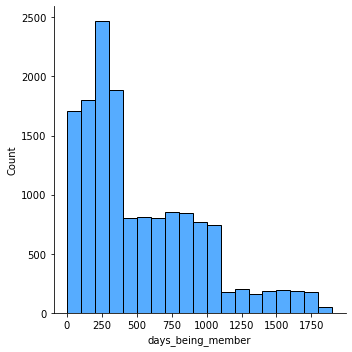

In [45]:
sns.displot(df_p, x="days_being_member", color='dodgerblue', binwidth=100);

The majority of users had an app for at least 885 days, which is less than 2.5 years.

#### Change values for `gender` column

In [46]:
df_p['gender'].value_counts()

M    8484
F    6124
O     212
Name: gender, dtype: int64

In [47]:
map_dict = {"F": 1,
            "M": 2,
            "O": 3}

In [48]:
df_p['gender'] = df_p['gender'].map(map_dict)

In [49]:
df_p['gender'].value_counts()

2    8484
1    6124
3     212
Name: gender, dtype: int64

Let's look at the cleaned and transfromed data

In [50]:
df_p.head()

,gender,age,id,became_member_on,income,days_being_member
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,"112,000.00",376
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,"100,000.00",443
5,2,68,e2127556f4f64592b11af22de27a7932,2018-04-26,"70,000.00",91
8,2,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,"53,000.00",167
12,2,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,"51,000.00",257


In [51]:
df_p['id'].nunique()

14820

We removed records for about 13% of unique users

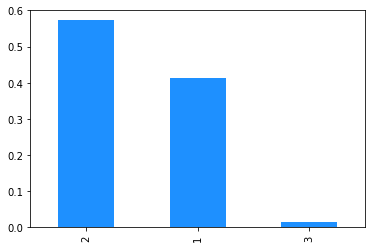

In [52]:
df_p['gender'].value_counts(normalize=True).plot.bar(color='dodgerblue');

Male users are dominant

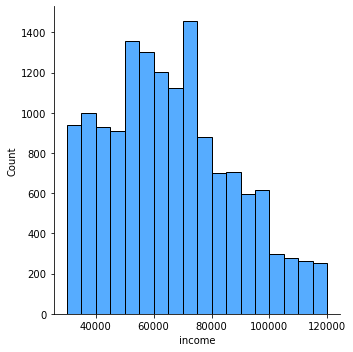

In [53]:
sns.displot(df_p, x="income", color='dodgerblue', binwidth=5000);

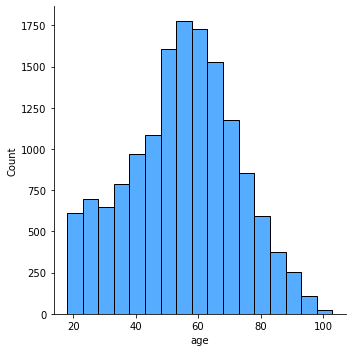

In [54]:
sns.displot(df_p, x="age", color='dodgerblue', binwidth=5);

In [55]:
# Let's change column name for 'id' to 'person' 
df_p.columns = ['gender', 'age', 'person', 'became_member_on', 'income', 'days_being_member']

In [56]:
df_p.head(2)

,gender,age,person,became_member_on,income,days_being_member
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,"112,000.00",376
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,"100,000.00",443


In [57]:
# Let's drop column 'became_member_on'
df_p.drop(columns=['became_member_on'], inplace=True)

In [58]:
# Let's save cleaned data
df_p.to_csv("./data/starbucks/profile_clean.csv", index=False)

### Transcript data

In [60]:
df_t.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Let's separate data into offers and transactions

In [61]:
df_tr = df_t[df_t['event'] == 'transaction']
df_off = df_t[df_t['event'] != 'transaction']

#### Engineering transaction features

In [63]:
df_tr.head(2)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0


In [66]:
print("Percentage of transaction data out of all records: ", (df_tr.shape[0] / df_t.shape[0])*100)

Percentage of transaction data out of all records:  45.33037118231583


In [67]:
df_tr['person'].nunique()

16578

In [75]:
# Create transaction amount column
df_tr['transaction_amount'] = df_tr['value'].str[11:16]
df_tr['transaction_amount'] = df_tr['transaction_amount'].str.replace('}', '')
df_tr['transaction_amount'] = df_tr['transaction_amount'].astype(float)

In [76]:
df_tr.head()

,person,event,value,time,transaction_amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97


In [77]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person              138953 non-null  object 
 1   event               138953 non-null  object 
 2   value               138953 non-null  object 
 3   time                138953 non-null  int64  
 4   transaction_amount  138953 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.4+ MB


In [78]:
# Create a column with transactions
df_tr['transaction'] = 1

In [79]:
df_tr.head()

,person,event,value,time,transaction_amount,transaction
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,1
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,1
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,1


Let's aggregate the transaction data per user using sum aggregation

In [ ]:
df_tr_agg = pd.groupby('person').agg()

In [ ]:
df_p['days_being_member'] = (df_p['became_member_on'].max() - df_p['became_member_on']).dt.days

In [ ]:
df_p['gender'].value_counts(normalize=True).plot.bar(color='dodgerblue');

In [ ]:
sns.displot(df_p, x="income", color='dodgerblue', binwidth=5000);

In [ ]:
df_p['became_member_on'].max()

In [ ]:
df_p['became_member_on'].min()

In [ ]:
df_p['days_being_member'].describe(percentiles=[0.8])

In [ ]:
sns.displot(df_p, x="days_being_member", color='dodgerblue', binwidth=100);

In [ ]:
df_p

In [ ]:
df_t.info()

In [ ]:
df_t['person'].nunique()

In [ ]:
df_t['event'].value_counts(normalize=True)

In [ ]:
df_t['value'].value_counts(normalize=True)

In [ ]:
df_t['value'].nunique()

In [ ]:
df_c = pd.read_csv("./data/starbucks/portfolio.csv")

In [ ]:
df_c.head()

In [ ]:
df_c.info()